<a href="https://colab.research.google.com/github/pingwx/ya.prac/blob/main/07_Supervised_learning/07_RU_Supervised_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Отток клиентов

В нашем распоряжении данные о клиентах банка "Бета-Банк". Заказчик обращает внимание, что за последнее время у него увеличился отток клиентов и просит построить модель для прогнозирования, уйдет клиент в ближайшее время или нет. Это позволит определить стратегию для отдела маркетинга.

**Описание данных**

- `RowNumber` — индекс строки в данных
- `CustomerId` — уникальный идентификатор клиента
- `Surname` — фамилия
- `CreditScore` — кредитный рейтинг
- `Geography` — страна проживания
- `Gender` — пол
- `Age` — возраст
- `Tenure` — сколько лет человек является клиентом банка
- `Balance` — баланс на счёте
- `NumOfProducts` — количество продуктов банка, используемых клиентом
- `HasCrCard` — наличие кредитной карты
- `IsActiveMember` — активность клиента
- `EstimatedSalary` — предполагаемая зарплата
- `Exited` — факт ухода клиента

## Подготовка данных

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

In [ ]:
df = pd.read_csv('/content/Churn.csv')

In [4]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Переименуем столбцы, согласно "змеиному регистру"

In [5]:
df.columns = ['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
             'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
             'is_active_member', 'estimated_salary', 'exited']

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   row_number        10000 non-null  int64  
 1   customer_id       10000 non-null  int64  
 2   surname           10000 non-null  object 
 3   credit_score      10000 non-null  int64  
 4   geography         10000 non-null  object 
 5   gender            10000 non-null  object 
 6   age               10000 non-null  int64  
 7   tenure            9091 non-null   float64
 8   balance           10000 non-null  float64
 9   num_of_products   10000 non-null  int64  
 10  has_cr_card       10000 non-null  int64  
 11  is_active_member  10000 non-null  int64  
 12  estimated_salary  10000 non-null  float64
 13  exited            10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Мы наблюдаем около 10% пропусков в столбце `tenure`. Согласно описанию данных, в этом столбце хранится количество лет, которые человек является клиентом банка. Предположим, что пропуски случаются, когда человек клиентом банка не является. Логично будет в этом случае заполнить пропуски нулями.

In [7]:
df['tenure'] = df['tenure'].fillna(0)

Целевым признаком для классификации является столбец `exited`. Посмотрим, как распределены классы.

In [8]:
df['exited'].value_counts()

0    7963
1    2037
Name: exited, dtype: int64

Признаков класса 0 примерно в 4 раза больше, чем признаков класса 1. Мы имеем дело с дисбалансом классов, с которым нам предстоит бороться в дальнейшем.

Отметим, что столбцы `row_number`, `customer_id` и `surname` признаками не являются. Остальные столбцы - признаки, кратко рассмотрим каждый из них

In [9]:
features = df[['credit_score', 'geography', 'gender', 'age', 'tenure', 'balance', 'num_of_products',
              'has_cr_card', 'is_active_member', 'estimated_salary']]

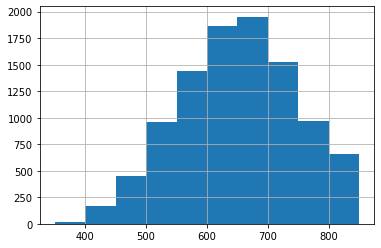

In [10]:
features['credit_score'].hist();

Распределение `credit_score` выглядит как нормальное, проблем в этом столбце нет.

In [11]:
features['geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: geography, dtype: int64

В столбце `geograhy` встречаются всего 3 значения, причем Germany и Spain в два раза более редкие, чем France.

In [12]:
features['gender'].value_counts()

Male      5457
Female    4543
Name: gender, dtype: int64

В столбце `gender` ожидаемо 2 значения, мужчин чуть больше, чем женщин

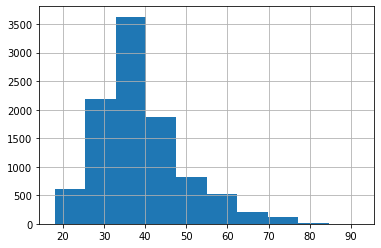

In [13]:
features['age'].hist();

Распределение возраста похоже на нормальное, немного скощенное влево.

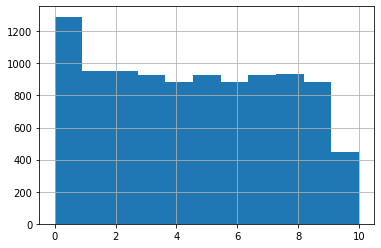

In [14]:
features['tenure'].hist(bins=11);

Распределение `tenure` выглядит как равномерное, с небольшим пиком в значении 0, что логично, т.к. ранее мы заполнили нулем пропуски.

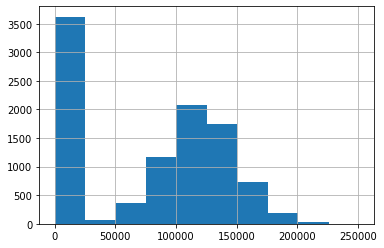

In [15]:
features['balance'].hist();

В столбце `balance` мы наблюдаем большой пик на значении 0, а остальные значения распределены нормально.

In [16]:
features['num_of_products'].value_counts()

1    5084
2    4590
3     266
4      60
Name: num_of_products, dtype: int64

В столбце `num_of_products` мы наблюдаем часто встречающиеся значения 1, 2, а значения 3, 4 встречаются редко.

In [17]:
features['has_cr_card'].value_counts()

1    7055
0    2945
Name: has_cr_card, dtype: int64

Столбец `has_cr_card` содержит 2 значения и является признаком наличия или отсутствия кредитной карты

In [18]:
features['is_active_member'].value_counts()

1    5151
0    4849
Name: is_active_member, dtype: int64

Снова два значения

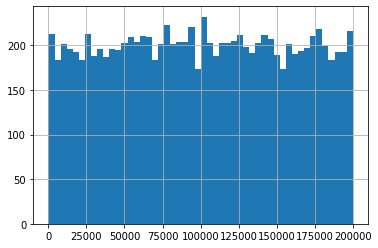

In [19]:
features['estimated_salary'].hist(bins=50);

Столбец `estimated_salary` распределен равномерно, выбросов не наблюдается

In [20]:
features.describe()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000
mean,650.528800,38.921800,4.543400,76485.889288,1.530200,0.70550,0.515100,100090.239881
std,96.653299,10.487806,3.111573,62397.405202,0.581654,0.45584,0.499797,57510.492818
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000
25%,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000
50%,652.000000,37.000000,4.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000


Потенциально проблемным столбцом является столбец `balance` из-за большого пика в нуле. Это видно и в describe, медиана сильно отличается от среднего.

В наших признаках есть два категориальных - `georhapy`, `gender`. Преобразуем их методом OHE, не забыв не попасть в дамми-ловушку.

In [21]:
features = pd.get_dummies(features, drop_first=True)

In [22]:
features.columns

Index(['credit_score', 'age', 'tenure', 'balance', 'num_of_products',
       'has_cr_card', 'is_active_member', 'estimated_salary',
       'geography_Germany', 'geography_Spain', 'gender_Male'],
      dtype='object')

Набор признаков `features` готов.

In [23]:
target = df['exited']

Целевой признак `target` готов.

Разобьем наши данные на обучающую, валидационную и тестовую выборки в соотношении 3:1:1. Сперва разобьем на два набора в соотношении 3:2

In [24]:
features_train, features_valid_and_test, target_train, target_valid_and_test = train_test_split(
    features, target, test_size=0.4, random_state=12345)

Затем второй набор разобьем пополам.

In [25]:
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid_and_test, target_valid_and_test, test_size=0.5, random_state=12345)

Проверим, что получилось.

In [26]:
print(features_train.shape) # размер обучающей выборки
print(target_train.shape)
print(features_valid.shape) # размер валидационной ваборки
print(target_valid.shape)
print(features_test.shape) # размер тестовой выборки
print(target_test.shape)

(6000, 11)
(6000,)
(2000, 11)
(2000,)
(2000, 11)
(2000,)


Все верно, выборки разбиты в соотношении 3:1:1

Для лучшей работы модели Logistic Regression стандартизируем признаки:

In [27]:
stdsc = StandardScaler()
features_train_std = stdsc.fit_transform(features_train)
features_valid_std = stdsc.transform(features_valid)

### Вывод:
На данном этапе мы выполнили подготовку данных. Мы заполнили пропуски и рассмотрели распределения признаков. Мы обнаружили, что целевой признак распределен неравномерно и в дальнейшем от нас потребуется балансировка классов. Мы преобразовали категориальные признаки методом OHE. Также мы разбили наши данные на обучающую, валидационную и тестовую выборки в соотношении 3:1:1

## Исследование задачи

Для начала определим функции `roc_curve_display` и `pr_curve_display`, которые помогут нам в дальнейшем выводить ROC-кривую и PR-кривую соответственно, во избежание многократного повторения кода.

In [28]:
#Функция вывода на экран roc-кривой (взята из тренажера)
def roc_curve_display(target, proba):
    fpr, tpr, thresholds = roc_curve(target, proba)
    plt.figure(figsize=(9, 9))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.show()
#Функция вывода на экран pr-кривой (взята из тренажера)    
def pr_curve_display(target, proba):
    precision, recall, thresholds = precision_recall_curve(target, proba)
    plt.figure(figsize=(9, 9))
    plt.step(recall, precision, where='post')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Кривая Precision-Recall')
    plt.show() 

Задачу классификации мы будем решать при помощи трех моделей: Decision Tree, Random Forest, Logistic Regression.

### Decision Tree

Определим функцию, в которой мы будем обучать модель Decision Tree, перебирая различные параметры. Описание входных параметров и возвращаемых данных - ниже в описании функции. Определяя функцию, мы избавляемся от повторения кода в дальнейшем.

In [29]:
#    Функция, в которой перебираются параметры модели DecisionTreeClassifier
#
#    Входные параметры:
#    features_train - признаки обучающей выборки
#    target_train - целевой признак обучающей выборки
#    features_valid - признаки валидационной выборки
#    target_valid - целевой признак валидационной выборки
#    class_balance - будем ли мы добавлять class_weight='balanced' в модель (False по умолчанию)
#    depth_min - минимальное значение гиперпараметра модели max_depth (1 по умолчанию)
#    depth_max - максимальное значение гиперпараметра модели max_depth (15 по умолчанию)
#    depth_by - шаг, с которым перебираются значения max_depth (1 по умолчанию)
#    threshold_min - минимальное пороговое значение (0 по умолчанию)
#    threshold_max - максимальное пороговое значение (1 по умолчанию)
#    threshold_by - шаг перебора порогового значение (0.05 по умолчанию)
#
#    Возвращает:
#    result_data - датафрейм, в котором записаны результаты работы модели со столбцами:
#
#                 'depth' - значение параметра max_depth
#                 'threshold' - значение порога
#                 'acc' - значение accuracy
#                 'precision' - значение precision
#                 'recall' - значение recall
#                 'f1_train' - значение f1_score для обучающей выборки (нужен, чтобы посмотреть на переобучение, например)
#                 'f1' - значение f1_score
#                 'auc_roc' - значение AUC ROC
#
#    best_model - модель с максимальным значение f1_score
#    best_result - максимальное значение f1_score
#    best_proba - массив вероятностей из predict_proba, для которого f1_score максимальное (нужен для графиков)
#    model_threshold - значение порога для модели с максимальным f1_score

def DTC_tuner(features_train, target_train, features_valid, target_valid, class_balance=False,
             depth_min=1, depth_max=15, depth_by=1, threshold_min=0, threshold_max=1,
             threshold_by=0.05):    
    best_model = None #инициализируем переменную, в которой будем хранить лучшую модель
    best_result = 0   #переменная, в которй будем хранить лучший результат
    result_data = []  #переменная, которая в последствие станет датафреймом с результатами
    for depth in range(depth_min, depth_max+1, depth_by):  #перебираем значения гиперпараметра max_depth
        if class_balance:
            model = DecisionTreeClassifier(max_depth=depth, random_state=12345, class_weight='balanced') #инициализация модели
        else:
            model = DecisionTreeClassifier(max_depth=depth, random_state=12345)
        model.fit(features_train, target_train) #обучили модель на обучающих признаках
        probabilities_valid = model.predict_proba(features_valid) #предсказали на валидационной выборке, сохранили вероятности
        probabilities_one_valid = probabilities_valid[:, 1] #вероятности класса 1
        probabilities_train = model.predict_proba(features_train) #предсказали на обучающей выборке
        probabilities_train_one_valid = probabilities_train[:, 1]
        for threshold in np.arange(threshold_min, threshold_max+0.01, threshold_by): #перебираем пороговые значения
            predicted_valid = probabilities_one_valid > threshold 
            predicted_train = probabilities_train_one_valid > threshold
            precision = precision_score(target_valid, predicted_valid, zero_division=0) #сохраняем значения метрик
            recall = recall_score(target_valid, predicted_valid)
            acc = accuracy_score(target_valid, predicted_valid)
            f1 = f1_score(target_valid, predicted_valid)
            f1_train = f1_score(target_train, predicted_train)   
            auc_roc = roc_auc_score(target_valid, predicted_valid)
            if f1 > best_result: #ищем наилучшую модель
                best_result = f1
                best_model = model
                best_proba = probabilities_valid[:, 1]
                model_threshold = threshold
            #записываем результаты в список
            result_data.append([depth, threshold, acc, precision, recall, f1_train, f1, auc_roc]) 
    #превращаем список в датафрейм
    result_data = pd.DataFrame(result_data, columns=['depth', 'threshold', 'acc', 'precision',
                                                     'recall', 'f1_train', 'f1', 'auc_roc'])
    return result_data, best_model, best_result, best_proba, model_threshold

Рассмотрим работу функции на несбалансированных классах, как есть. Будем перебирать значения гиперпараметра `max_depth` от 1 до 15 (это значения функции `DTC_tuner` по умолчанию, их можно менять). Пороговое значение классификации будем перебирать с шагом 0.05 (так же значение параметра по умолчанию).

In [30]:
result_data, best_model, best_result, best_proba, model_threshold = DTC_tuner(features_train, target_train, 
                                                                             features_valid, target_valid)
print('best model:', best_model,'threshold =', '%.2f'%model_threshold)
print()
print('best f1_score:', best_result)
print()
result_data.query('threshold == 0.5')

best model: DecisionTreeClassifier(max_depth=6, random_state=12345) threshold = 0.30

best f1_score: 0.5987577639751551



,depth,threshold,acc,precision,recall,f1_train,f1,auc_roc
10,1,0.5,0.7910,0.000000,0.000000,0.000000,0.000000,0.500000
31,2,0.5,0.8240,0.603774,0.459330,0.514258,0.521739,0.689842
52,3,0.5,0.8380,0.826389,0.284689,0.415716,0.423488,0.634443
73,4,0.5,0.8520,0.750000,0.437799,0.539446,0.552870,0.699620
94,5,0.5,0.8530,0.779279,0.413876,0.557912,0.540625,0.691451
115,6,0.5,0.8580,0.776860,0.449761,0.596842,0.569697,0.707813
136,7,0.5,0.8505,0.769231,0.406699,0.622881,0.532081,0.687230
157,8,0.5,0.8505,0.748954,0.428230,0.647338,0.544901,0.695151
178,9,0.5,0.8500,0.700680,0.492823,0.710704,0.578652,0.718599
199,10,0.5,0.8340,0.649306,0.447368,0.738142,0.529745,0.691763


Мы получили максимальное значение метрики `f1_score` равное 0.599 при значении параметра `max_depth` равном 6 и пороговом значении 0.3. Значения метрик при дефолтном пороговом значении 0.5 в зависимости от значения `max_depth` выведены на экран. Обратим внимание, что после значения `max_depth`= 9 значение метрики f1_score начинает снижаться, в то время как для обучающей выборки оно растет, таким образом при значениях `max_depth` больше 9 модель выглядит переобученной. Посмотрим также, чему равно максимальное значение метрики `AUC-ROC`.

In [31]:
print('best AUC-ROC:', result_data['auc_roc'].max())

best AUC-ROC: 0.7495992596132326


Максимальное значение `AUC-ROC` наблюдается при `max_depth` 7 и пороговом значении 0.15. Обратим внимание, что `f1_score` при таких параметрах существенно ниже максимальной. Построим графики величин `f1_score` и `auc_roc` в зависимости от глубины `max_depth` при стандартном пороговом значении 0.5

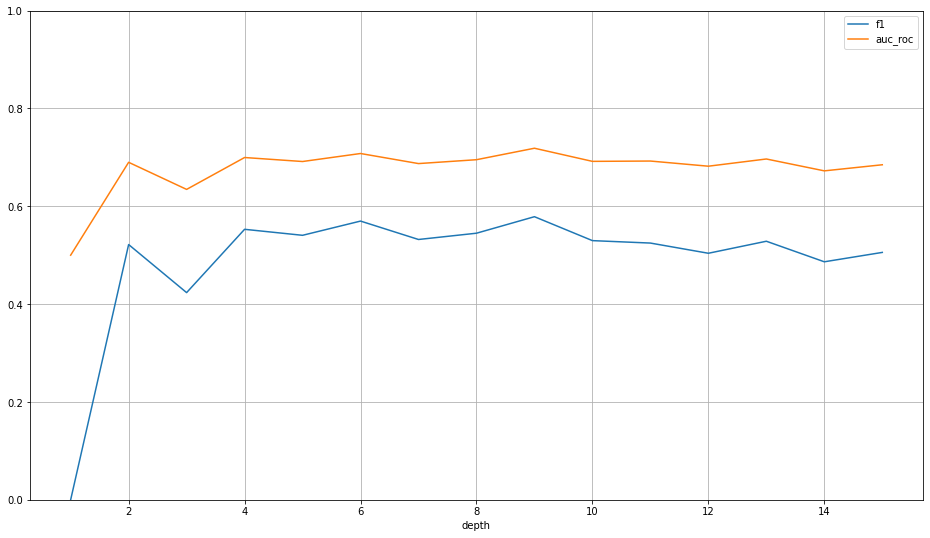

In [32]:
result_data.query('threshold == 0.5').plot(x='depth', y=['f1', 'auc_roc'], ylim=(0, 1), figsize=(16,9), grid=True);

Построим ROC-кривую и PR-кривую.

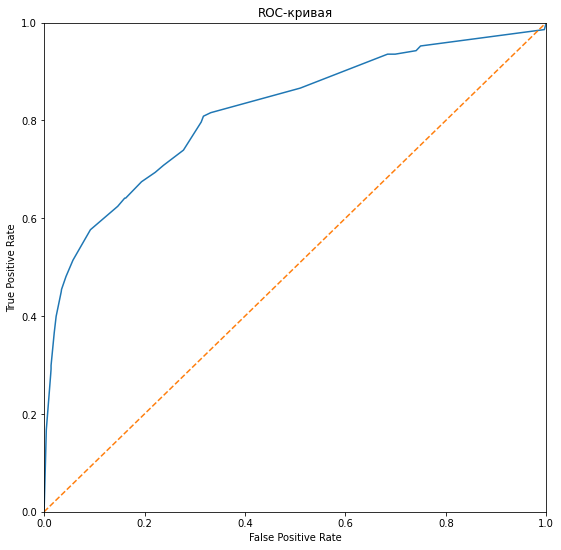

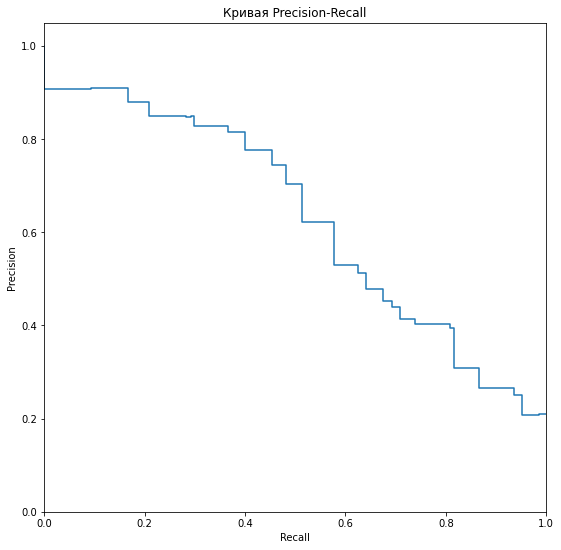

In [33]:
roc_curve_display(target_valid, best_proba)
pr_curve_display(target_valid, best_proba)

### Random Forest

Как и для Decision Tree, объявим функцию, которая поможет нам с перебором параметров.

In [34]:
#    Функция, в которой перебираются параметры модели RandomForestClassifier
#
#    Входные параметры:
#    features_train - признаки обучающей выборки
#    target_train - целевой признак обучающей выборки
#    features_valid - признаки валидационной выборки
#    target_valid - целевой признак валидационной выборки
#    class_balance - будем ли мы добавлять class_weight='balanced' в модель (False по умолчанию)
#    tune_depth - необходимость перебора параметра max_depth (по умолчанию False, max_depth не перебираем)
#    depth_min - минимальное значение гиперпараметра модели max_depth (1 по умолчанию)
#    depth_max - максимальное значение гиперпараметра модели max_depth (15 по умолчанию)
#    depth_by - шаг, с которым перебираются значения max_depth (1 по умолчанию)
#    est_min - минимальное значение гиперпараметра модели n_estimators (1 по умолчанию)
#    est_max - максимальное значение гиперпараметра модели n_estimators (251 по умолчанию)
#    est_by - шаг, с которым перебираются значения n_estimators (25 по умолчанию)
#    threshold_min - минимальное пороговое значение (0 по умолчанию)
#    threshold_max - максимальное пороговое значение (1 по умолчанию)
#    threshold_by - шаг перебора порогового значение (0.05 по умолчанию)
#
#    Возвращает:
#    result_data - датафрейм, в котором записаны результаты работы модели со столбцами:
#
#                 'depth' - значение параметра max_depth (если max_depth не перебирали, записываем 0)
#                 'est' - количество деревьев
#                 'threshold' - значение порога
#                 'acc' - значение accuracy
#                 'precision' - значение precision
#                 'recall' - значение recall
#                 'f1_train' - значение f1_score для обучающей выборки (нужен, чтобы посмотреть на переобучение, например)
#                 'f1' - значение f1_score
#                 'auc_roc' - значение AUC ROC
#
#    best_model - модель с максимальным значение f1_score
#    best_result - максимальное значение f1_score
#    best_proba - массив вероятностей из predict_proba, для которого f1_score максимальное (нужен для графиков)
#    model_threshold - значение порога для модели с максимальным f1_score

def RFC_tuner(features_train, target_train, features_valid, target_valid, class_balance=False, tune_depth=False,
             depth_min=1, depth_max=15, depth_by=1, est_min=1, est_max=251, est_by=25,
             threshold_min=0, threshold_max=1, threshold_by=0.05): 
    best_model = None #инициализируем переменную, в которой будем хранить лучшую модель
    best_result = 0   #переменная, в которй будем хранить лучший результат
    result_data = []  #переменная, которая в последствие станет датафреймом с результатами
    if not tune_depth: # если перебирать max_depth не нужно, устанавливаем значения, чтобы внешний цикл сработал 1 раз
        depth_min = 0
        depth_max = 0
        depth_by = 1
    for depth in range(depth_min, depth_max + 1, depth_by): #внешний цикл, перебирающий значения параметра max_depth
        for est in range(est_min, est_max + 1, est_by): #внутренний цикл, перебор n_estimators
            #инициализация модели в зависимости от признаков tune_depth и class_balance
            if tune_depth:
                if class_balance:
                    model = RandomForestClassifier(max_depth=depth, n_estimators=est,
                                                   random_state=12345, class_weight='balanced')
                else:
                    model = RandomForestClassifier(max_depth=depth, n_estimators=est, random_state=12345)
            else:
                if class_balance:
                    model = RandomForestClassifier(n_estimators=est, random_state=12345, class_weight='balanced')
                else:
                     model = RandomForestClassifier(n_estimators=est, random_state=12345)
            model.fit(features_train, target_train) #обучение модели
            probabilities_valid = model.predict_proba(features_valid) #предсказали на валидационной выборке, сохранили вероятности
            probabilities_one_valid = probabilities_valid[:, 1] #вероятности класса 1
            probabilities_train = model.predict_proba(features_train) #предсказали на обучающей выборке
            probabilities_train_one_valid = probabilities_train[:, 1]
            for threshold in np.arange(threshold_min, threshold_max+0.01, threshold_by): #перебираем пороговые значения
                predicted_valid = probabilities_one_valid > threshold
                predicted_train = probabilities_train_one_valid > threshold
                precision = precision_score(target_valid, predicted_valid, zero_division=0) #сохраняем значения метрик
                recall = recall_score(target_valid, predicted_valid)
                acc = accuracy_score(target_valid, predicted_valid)
                f1 = f1_score(target_valid, predicted_valid)
                f1_train = f1_score(target_train, predicted_train)   
                auc_roc = roc_auc_score(target_valid, predicted_valid)
                if f1 > best_result: #ищем наилучшую модель
                    best_result = f1
                    best_model = model
                    best_proba = probabilities_valid[:, 1]
                    model_threshold = threshold
                #записываем результаты в список
                result_data.append([depth, est, threshold, acc, precision, recall, f1_train, f1, auc_roc])
    #превращаем список в датафрейм
    result_data = pd.DataFrame(result_data, columns=['depth', 'est', 'threshold', 'acc', 'precision', 'recall',
                                                     'f1_train', 'f1', 'auc_roc'])
    return result_data, best_model, best_result, best_proba, model_threshold

Наша функция позволяет перебирать гиперпараметры `max_depth`, `n_estimators`, но по умолчанию перебирается только `n_estimators`. Посмотрим на результат работы функции, перебирающей `n_estimators` в диапазоне от 1 до 251 с шагом 25 (значения функции по умолчанию).

In [35]:
result_data, best_model, best_result, best_proba, model_threshold = RFC_tuner(features_train, target_train,
                                                                              features_valid, target_valid)
print('best model:', best_model,'threshold =', '%.2f'%model_threshold)
print()
print('best f1_score:', best_result)
print()
result_data.query('threshold == 0.5')

best model: RandomForestClassifier(n_estimators=101, random_state=12345) threshold = 0.35

best f1_score: 0.6318347509113



,depth,est,threshold,acc,precision,recall,f1_train,f1,auc_roc
10,0,1,0.5,0.7860,0.488532,0.509569,0.820513,0.498829,0.684304
31,0,26,0.5,0.8580,0.770161,0.456938,0.991575,0.573574,0.710454
52,0,51,0.5,0.8610,0.763158,0.485646,0.998325,0.593567,0.722911
73,0,76,0.5,0.8580,0.759690,0.468900,0.999582,0.579882,0.714854
94,0,101,0.5,0.8590,0.763566,0.471292,0.999582,0.582840,0.716367
115,0,126,0.5,0.8595,0.764479,0.473684,0.999582,0.584934,0.717563
136,0,151,0.5,0.8590,0.761538,0.473684,1.000000,0.584071,0.717247
157,0,176,0.5,0.8575,0.762846,0.461722,1.000000,0.575261,0.711898
178,0,201,0.5,0.8570,0.759843,0.461722,1.000000,0.574405,0.711582
199,0,226,0.5,0.8570,0.757812,0.464115,1.000000,0.575668,0.712462


Значение метрики `f1_score` выросло по сравнению с Decision Tree, что ожидаемо. Выросло и время выполнения кода. Снова выведены значения метрик при стандартном пороговом значении 0.5 в зависимости от числа `n_estimators`. Снова посмотрим на максимальное `AUC-ROC`, на график метрик `AUC-ROC` и `f1_score` в зависимости от параметра `n_estimators`, а также выведем ROC-кривую и PR-кривую

In [36]:
print('best AUC-ROC:', result_data['auc_roc'].max())

best AUC-ROC: 0.7746689733182514


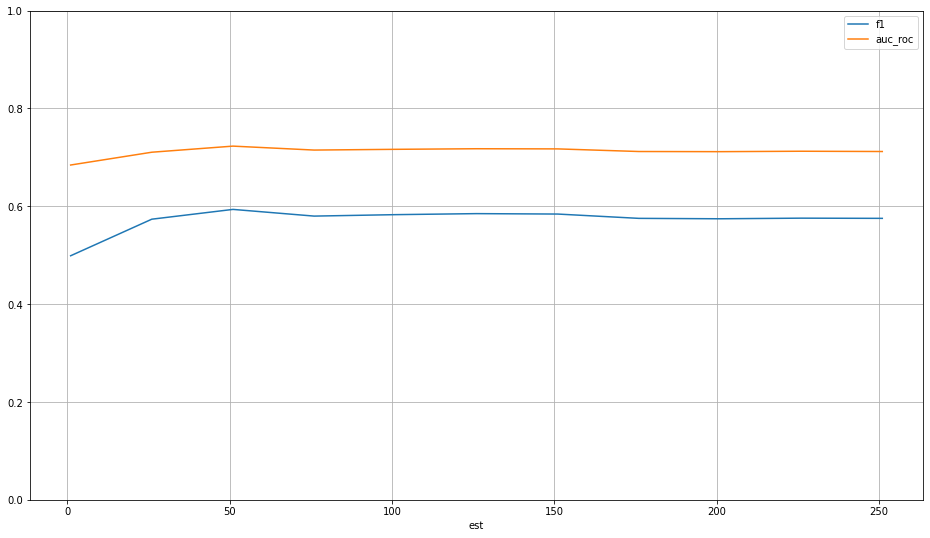

In [37]:
result_data.query('threshold == 0.5').plot(x='est', y=['f1', 'auc_roc'], ylim=(0, 1), figsize=(16,9), grid=True);

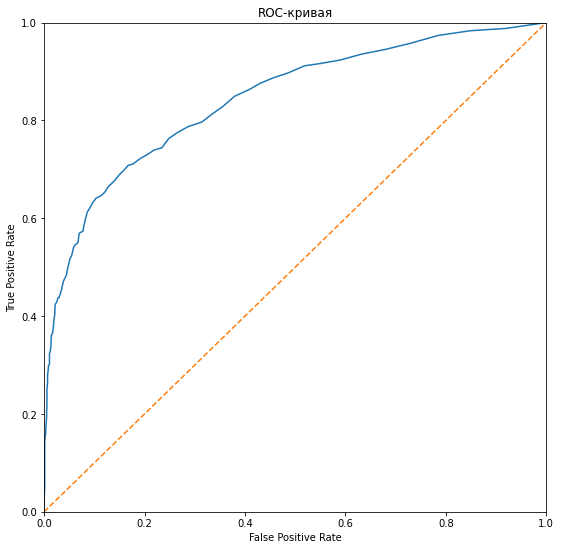

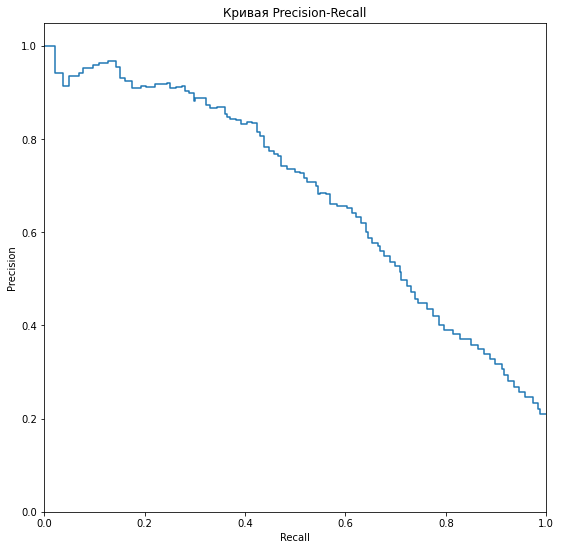

In [38]:
roc_curve_display(target_valid, best_proba)
pr_curve_display(target_valid, best_proba)

Попробуем перебирать одновременно два гиперпараметра `n_estimators` и `max_depth`, для этого укажем в нашей функции параметр `tune_depth=True`. Внимание: код выполняется около трех минут.

In [39]:
%%time
result_data, best_model, best_result, best_proba, model_threshold = RFC_tuner(features_train, target_train,
                                                                              features_valid, target_valid,
                                                                              tune_depth=True)
print('best model:', best_model,'threshold =', '%.2f'%model_threshold)
print()
print('best f1_score:', best_result)
print('best AUC-ROC:', result_data['auc_roc'].max())

best model: RandomForestClassifier(max_depth=11, n_estimators=126, random_state=12345) threshold = 0.30

best f1_score: 0.6451612903225807
best AUC-ROC: 0.7852787640864027
CPU times: user 3min 11s, sys: 583 ms, total: 3min 12s
Wall time: 3min 35s


Таким образом мы добились лучшей работы Random Forest по сравнению с перебором только параметра `n_estimators`. Обе метрики `f1_score` и `auc_roc` выросли.

### Logistic Regression

Исследуем еще одну модель - Logistic Regression. Снова определим функцию для перебора параметров.

In [40]:
#    Функция, в которой перебираются параметры модели LogisticRegression
#
#    Входные параметры:
#    features_train - признаки обучающей выборки
#    target_train - целевой признак обучающей выборки
#    features_valid - признаки валидационной выборки
#    target_valid - целевой признак валидационной выборки
#    class_balance - будем ли мы добавлять class_weight='balanced' в модель (False по умолчанию)
#    solver - значение параметра solver модели ('liblinear' по умолчанию)
#    threshold_min - минимальное пороговое значение (0 по умолчанию)
#    threshold_max - максимальное пороговое значение (1 по умолчанию)
#    threshold_by - шаг перебора порогового значение (0.05 по умолчанию)
#
#    Возвращает:
#    result_data - датафрейм, в котором записаны результаты работы модели со столбцами:
#
#                 'threshold' - значение порога
#                 'acc' - значение accuracy
#                 'precision' - значение precision
#                 'recall' - значение recall
#                 'f1_train' - значение f1_score для обучающей выборки (нужен, чтобы посмотреть на переобучение, например)
#                 'f1' - значение f1_score
#                 'auc_roc' - значение AUC ROC
#
#    best_model - модель с максимальным значение f1_score
#    best_result - максимальное значение f1_score
#    best_proba - массив вероятностей из predict_proba, для которого f1_score максимальное (нужен для графиков)
#    model_threshold - значение порога для модели с максимальным f1_score

def LR_tuner(features_train, target_train, features_valid, target_valid, class_balance=False,
             solver='liblinear', threshold_min=0, threshold_max=1, threshold_by=0.05):    
    best_model = None #инициализируем переменную, в которой будем хранить лучшую модель
    best_result = 0   #переменная, в которй будем хранить лучший результат
    result_data = []  #переменная, которая в последствие станет датафреймом с результатами 
    if class_balance:
        model = LogisticRegression(random_state=12345, solver=solver, class_weight='balanced') #инициализация модели
    else:
        model = LogisticRegression(solver=solver, random_state=12345) 
    model.fit(features_train, target_train) #обучили модель на обучающих признаках
    probabilities_valid = model.predict_proba(features_valid) #предсказали на валидационной выборке, сохранили вероятности
    probabilities_one_valid = probabilities_valid[:, 1] #вероятности класса 1
    probabilities_train = model.predict_proba(features_train) #предсказали на обучающей выборке
    probabilities_train_one_valid = probabilities_train[:, 1]
    for threshold in np.arange(threshold_min, threshold_max+0.01, threshold_by): #перебираем пороговые значения
        predicted_valid = probabilities_one_valid > threshold 
        predicted_train = probabilities_train_one_valid > threshold
        precision = precision_score(target_valid, predicted_valid, zero_division=0) #сохраняем значения метрик
        recall = recall_score(target_valid, predicted_valid)
        acc = accuracy_score(target_valid, predicted_valid)
        f1 = f1_score(target_valid, predicted_valid)
        f1_train = f1_score(target_train, predicted_train)   
        auc_roc = roc_auc_score(target_valid, predicted_valid)
        if f1 > best_result: #ищем наилучшую модель
            best_result = f1
            best_model = model
            best_proba = probabilities_valid[:, 1]
            model_threshold = threshold
        result_data.append([threshold, acc, precision, recall, f1_train, f1, auc_roc]) #записываем результаты в список
    #превращаем список в датафрейм
    result_data = pd.DataFrame(result_data, columns=['threshold', 'acc', 'precision',
                                                     'recall', 'f1_train', 'f1', 'auc_roc'])
    return result_data, best_model, best_result, best_proba, model_threshold

В отличие от Decision Tree и Random Forest, на Logistic Regression влияет масштабирование признаков, однако сперва обучим модель на немасштабированных признаках и несбалансированных классах.

In [41]:
result_data, best_model, best_result, best_proba, model_threshold = LR_tuner(features_train, target_train,
                                                                              features_valid, target_valid)
print('best model:', best_model,'threshold =', '%.2f'%model_threshold)
print()
print('best f1_score:', best_result)
print()
result_data

best model: LogisticRegression(random_state=12345, solver='liblinear') threshold = 0.20

best f1_score: 0.41379310344827586



,threshold,acc,precision,recall,f1_train,f1,auc_roc
0,0.00,0.2090,0.209000,1.000000,0.332407,0.345740,0.500000
1,0.05,0.2275,0.212939,1.000000,0.335631,0.351113,0.511694
2,0.10,0.3395,0.234880,0.956938,0.360212,0.377181,0.566648
3,0.15,0.4815,0.261372,0.811005,0.387006,0.395335,0.602721
4,0.20,0.6175,0.304397,0.645933,0.403040,0.413793,0.627960
5,0.25,0.6955,0.337308,0.473684,0.397124,0.394030,0.613896
6,0.30,0.7325,0.356968,0.349282,0.366209,0.353083,0.591519
7,0.35,0.7600,0.382576,0.241627,0.307135,0.296188,0.569296
8,0.40,0.7760,0.410714,0.165072,0.231554,0.235495,0.551246
9,0.45,0.7785,0.368421,0.083732,0.143345,0.136452,0.522903


Хоть скорость работы очень высокая, результаты очень слабые.

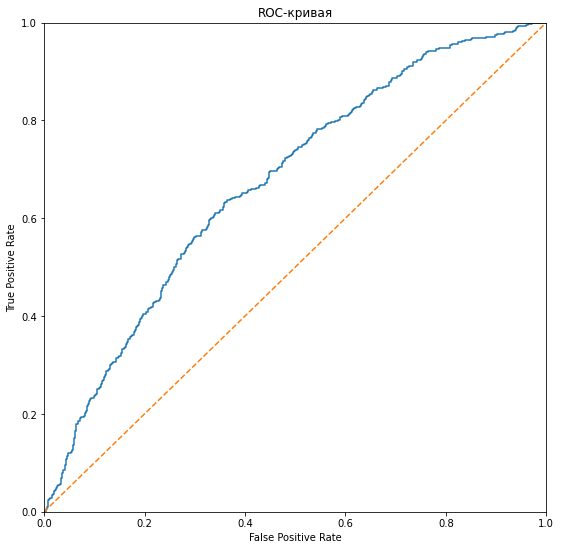

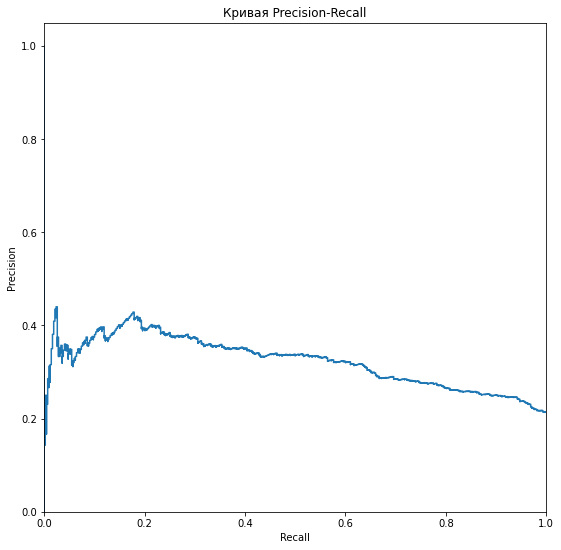

In [42]:
roc_curve_display(target_valid, best_proba)
pr_curve_display(target_valid, best_proba)

Проверим работу модели на отмасштабированных признаках.

In [44]:
result_data, best_model, best_result, best_proba, model_threshold = LR_tuner(features_train_std, target_train,
                                                                              features_valid_std, target_valid,
                                                                            )
print('best model:', best_model,'threshold =', '%.2f'%model_threshold)
print()
print('best f1_score:', best_result)
print()
print('best AUC-ROC:', result_data['auc_roc'].max()) #вывод строки датасета с масимальным AUC-ROC

best model: LogisticRegression(random_state=12345, solver='liblinear') threshold = 0.25

best f1_score: 0.496551724137931

best AUC-ROC: 0.6923962158009667


После масштабирования результаты значительно улучшились, однако все еще далеки от результатов Random Forest.

### Вывод:

Мы рассмотрели работу трех моделей на несбалансированных классах. Модель Random Forest показывает наилучшие результаты, но процесс подбора параметров и обучения занимает весьма долгое время. Наилучший `f1_score` наблюдается у модели RandomForestClassifier с параметрами `max_depth=11`, `n_estimators=126` и пороговым значением 0.3. Наилучший `AUC-ROC` у RandomForestClassifier с параметрами `max_depth=10`, `n_estimators=151` и пороговым значением 0.25

## Борьба с дисбалансом

В этом разделе мы попытаемся добиться баланса классов при помощи двух подходов: взвешивания и даунсэмплинга.

### Взвешивание

В наших функциях, обучающих модели и перебирающих параметры мы предусмортели возможность взвешивания классов. Посмотрим на их работу с учетом взвешивания. Decision Tree:

In [45]:
result_data, best_model, best_result, best_proba, model_threshold = DTC_tuner(features_train, target_train, 
                                                                             features_valid, target_valid,
                                                                             class_balance=True)
print('best model:', best_model,'threshold =', '%.2f'%model_threshold)
print()
print('best f1_score:', best_result)
print()
print('best AUC-ROC:', result_data['auc_roc'].max())

best model: DecisionTreeClassifier(class_weight='balanced', max_depth=5, random_state=12345) threshold = 0.60

best f1_score: 0.6082004555808656

best AUC-ROC: 0.7587588238496482


Обе метрики `f1_score` и `AUC-ROC` выросли после взвешивания.

Посмотрим на работу Random Forest с учетом взвешивания. Перебор будем вести и по `max_depth` и по `n_estimators`, чтобы постараться получить наилучший результат. Это снова займет около трех минут на выполнение.

In [46]:
result_data, best_model, best_result, best_proba, model_threshold = RFC_tuner(features_train, target_train, 
                                                                             features_valid, target_valid,
                                                                             class_balance=True, tune_depth=True)
print('best model:', best_model,'threshold =', '%.2f'%model_threshold)
print()
print('best f1_score:', best_result)
print()
print('best AUC-ROC:', result_data['auc_roc'].max())

best model: RandomForestClassifier(class_weight='balanced', max_depth=6, n_estimators=201,
                       random_state=12345) threshold = 0.55

best f1_score: 0.6437571592210768

best AUC-ROC: 0.7882941464683432


Значения метрик `f1_score` и `AUC-ROC` слегка уменьшились, однако незначительно (было 0.645 и 0.785 соответственно).

Рассмотрим также работу Logistic Regression с учетом взвешивания классов. Обучать модель будем на масштабированных признаках.

In [47]:
result_data, best_model, best_result, best_proba, model_threshold = LR_tuner(features_train_std, target_train, 
                                                                             features_valid_std, target_valid,
                                                                             class_balance=True)
print('best model:', best_model,'threshold =', '%.2f'%model_threshold)
print()
print('best f1_score:', best_result)
print()
print('best AUC-ROC:', result_data['auc_roc'].max()) 

best model: LogisticRegression(class_weight='balanced', random_state=12345,
                   solver='liblinear') threshold = 0.55

best f1_score: 0.500952380952381

best AUC-ROC: 0.6979687755188454


Метрики `f1_score` и `AUC-ROC` слегка улучшились после взвешивания классов для модели Logistic Regression.

### Даунсэмплинг

Попытаемся добиться баланса классов применяя даунсэмплинг. Для этого случайным образом будем выкидывать некоторую часть выборки, таким образом, чтобы соотношение классов стало приблизительно равным. Определим функцию для даунсэмплинга

In [48]:
#Фунция, выполняющая даунсэмплинг (взята из тренажера)
#Входные параметры: features - признаки, traget - целевой признак, fraction - доля, которую нужно оставить
#Выводит: features_downsampled - сокращенная выборка признаков, target - сокращенный целевой признак
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)    
    return features_downsampled, target_downsampled

Вспомним, как распределены классы:

In [49]:
target.value_counts()

0    7963
1    2037
Name: exited, dtype: int64

Соотношение примерно 4:1. Таким образом, для того, чтобы классы стали сбалансированными, нам надо задать значение `fraction` равным 0.25.

In [50]:
features_train_ds, target_train_ds = downsample(features_train, target_train, 0.25)

Даунсэмплинг выполнен. Расссмотрим работу моделей. Decision Tree:

In [51]:
result_data, best_model, best_result, best_proba, model_threshold = DTC_tuner(features_train_ds, target_train_ds, 
                                                                             features_valid, target_valid,
                                                                             )
print('best model:', best_model,'threshold =', '%.2f'%model_threshold)
print()
print('best f1_score:', best_result)
print()
print('best AUC-ROC:', result_data['auc_roc'].max()) #вывод строки датасета с масимальным AUC-ROC

best model: DecisionTreeClassifier(max_depth=5, random_state=12345) threshold = 0.65

best f1_score: 0.6093189964157707

best AUC-ROC: 0.762931060555653


Даунсэмплинг улучшил результат Decision Tree по сравнению с обучением на несбалансированных классах. Также `f1_score` слегка вырос по сравнению с `f1_score` на взвешенных классах.

Random Forest. На этот раз перебирать `max_depth` не будем, чтобы ускорить время работы.

In [52]:
result_data, best_model, best_result, best_proba, model_threshold = RFC_tuner(features_train_ds, target_train_ds, 
                                                                             features_valid, target_valid,
                                                                             )
print('best model:', best_model,'threshold =', '%.2f'%model_threshold)
print()
print('best f1_score:', best_result)
print()
print('best AUC-ROC:', result_data['auc_roc'].max())  #вывод строки датасета с масимальным AUC-ROC

best model: RandomForestClassifier(n_estimators=101, random_state=12345) threshold = 0.65

best f1_score: 0.616891064871481

best AUC-ROC: 0.7737208064408809


Метрики `f1_score`, `AUC-ROC` незначительно ухудшились (были 0.632 и 0.774 соответственно).

Logistic Regression. Необходимо вспомнить, что мы делали масштабирование и произвести даунсемплинг для масштабированных признаков.

In [53]:
features_train_std_ds, target_train_ds = downsample(features_train, target_train, 0.25)

In [54]:
result_data, best_model, best_result, best_proba, model_threshold = LR_tuner(features_train_std_ds, target_train_ds, 
                                                                             features_valid_std, target_valid,
                                                                             )
print('best model:', best_model,'threshold =', '%.2f'%model_threshold)
print()
print('best f1_score:', best_result)
print()
print('best AUC-ROC:', result_data['auc_roc'].max()) #вывод строки датасета с масимальным AUC-ROC

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"


best model: LogisticRegression(random_state=12345, solver='liblinear') threshold = 0.50

best f1_score: 0.44230769230769235

best AUC-ROC: 0.6569601800156061


Метрики `f1_score` и `AUC-ROC` ухудшились

### Вывод:

Мы попытались побороть дисбаланс классов при помощи взвешивания и даунсэмплинга. Для некоторых моделей это дало плоды, для других - результат обратный. Взвешивание улучшило работу Decision Tree и Logistic Regression. Результат работы Random Forest остался практически неизменным после взвешивания. Даунсэмплинг также улучшил работу Decision Tree, однако для Random Forest и Logistic Regression привел к ухудшению результата. Отметим также, что за все время исследования наилучшая метрика по-прежнему остается у модели, обученной на несбалансированных классах, а именно RandomForestClassifier с параметрами `max_depth=11`, `n_estimators=126` и пороговым значением 0.3

## Тестирование модели

Посмотрим работу наилучшей найденной нами модели на тестовой выборке, подставим в нашу функцию `RFC_tuner` параметры наилучшей модели, найденной в результате исследования.

In [55]:
result_data, best_model, best_result, best_proba, model_threshold = RFC_tuner(features_train, target_train, 
                                                                              features_test, target_test,
                                                                              tune_depth=True, depth_min=11,
                                                                              depth_max=11, est_min=126, est_max=126,
                                                                              threshold_min=0.3, threshold_max=0.3,
                                                                             )
print('model:', best_model)
result_data

model: RandomForestClassifier(max_depth=11, n_estimators=126, random_state=12345)


,depth,est,threshold,acc,precision,recall,f1_train,f1,auc_roc
0,11,126,0.3,0.835,0.605442,0.631206,0.857377,0.618056,0.760435


Метрики `f1_score` и `AUC-ROC` слегка ниже, чем на валидационной выборке, однако остаются приемлемыми. Построим ROC-кривую и PR-кривую

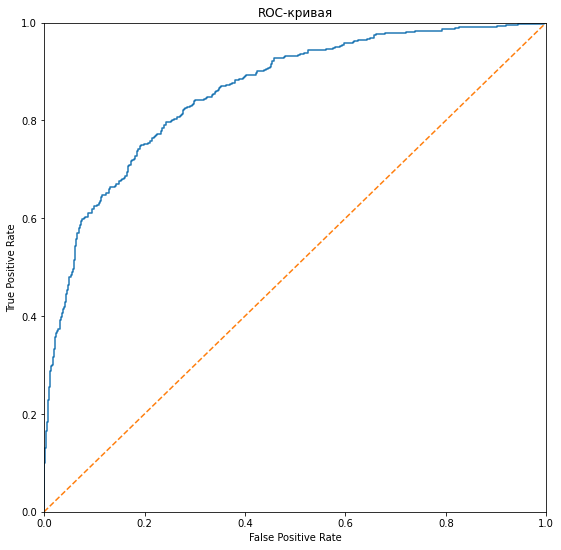

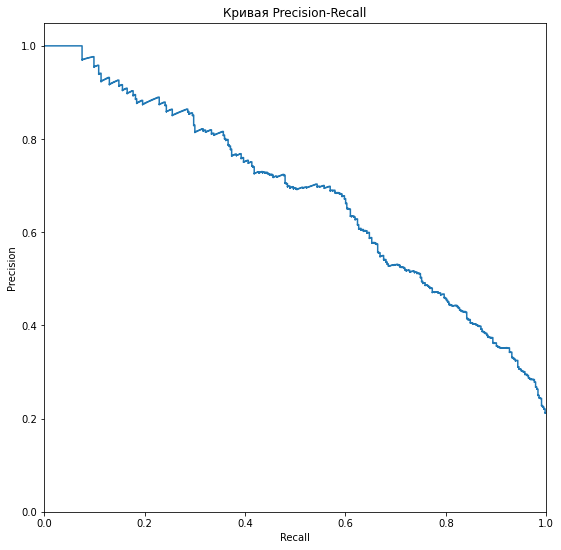

In [56]:
roc_curve_display(target_test, best_proba)
pr_curve_display(target_test, best_proba)

## Вывод

Мы научились прогнозировать отток клиентов "Бета-Банка". Мы смогли подобрать модель и ее параметры, удовлетворяющие заказчика. Ей оказалась модель RandomForestClassifier с параметрами `max_depth =11`, `n_estimators=126` и пороговым значением 0.3. Модель прекрасно показала себя на тестировании. Заказчик доволен.  Посмотрим на важность признаков

In [57]:
best_model.feature_importances_

array([0.10509548, 0.28168842, 0.05632585, 0.11577564, 0.18229338,
       0.01417226, 0.06092511, 0.10430349, 0.04721388, 0.00992455,
       0.02228194])

In [58]:
features.columns

Index(['credit_score', 'age', 'tenure', 'balance', 'num_of_products',
       'has_cr_card', 'is_active_member', 'estimated_salary',
       'geography_Germany', 'geography_Spain', 'gender_Male'],
      dtype='object')